In [1]:
import json
from IPython.display import display, HTML
import matplotlib
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

with open("result.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
print('Results file loaded successfully.')

def extract_groups(data):
    # Handles both old and new structures
    groups = []
    if isinstance(data, dict) and 'groups_details' in data:
        groups = data['groups_details']
    elif isinstance(data, list):
        # List of investigations, each with groups_details
        for inv in data:
            if isinstance(inv, dict) and 'groups_details' in inv:
                groups.extend(inv['groups_details'])
    return groups

Results file loaded successfully.


In [2]:
if 'data' in locals():
    groups = extract_groups(data)
    if not groups:
        print("No groups to display.")
    else:
        # Only process groups with inves_type == 'vel_coeffs'
        total_groups = len(groups)
        vel_coeffs_groups = sum(1 for g in groups if g.get('inves_type') == 'vel_coeffs')
        print(f"Total number of groups: {total_groups}")
        print(f"Number of groups of Velocity Coefficient experiments: {vel_coeffs_groups}")
        for group in groups:
            if group.get('inves_type') == 'vel_coeffs':
                group_id = group.get('id', group.get('group_id', group.get('group', 'N/A')))
                print(f"\nGroup: {group_id}")
                # Print metadata (all keys except 'exps_details')
                meta = {k: v for k, v in group.items() if k != 'exps_details'}
                print("Metadata:", meta)
                # Prepare table from exps_details key, extracting nested fields
                exps_details = group.get('exps_details', [])
                if not exps_details:
                    print("No exps_details in this group.")
                    continue
                rows = []
                for exp in exps_details:
                    pso = exp.get('pso_params', {})
                    res = exp.get('results', {})
                    w_inertia = pso.get('w_inertia', None)
                    c_personal = pso.get('c_personal', None)
                    c_global = pso.get('c_global', None)
                    c_social = pso.get('c_social', None)
                    sum_all = None
                    sum_coeffs = None
                    if all(x is not None for x in [w_inertia, c_personal, c_global, c_social]):
                        sum_all = w_inertia + c_personal + c_global + c_social
                        sum_coeffs = c_personal + c_global + c_social
                    row = {
                        'w_inertia': w_inertia,
                        'c_personal': c_personal,
                        'c_global': c_global,
                        'c_social': c_social,
                        'avg_training_cost': res.get('avg_training_cost', None),
                        'sum_inertia_and_coeffs': sum_all,
                        'sum_coeffs': sum_coeffs
                    }
                    rows.append(row)
                table_df = pd.DataFrame(rows)
                # Use the specified fields and order
                required_cols = ['w_inertia', 'c_personal', 'c_global', 'c_social', 'avg_training_cost', 'sum_inertia_and_coeffs', 'sum_coeffs']
                missing = [col for col in required_cols if col not in table_df.columns]
                if missing:
                    print(f"Missing columns in exps_details: {missing}")
                    continue
                table_df = table_df[required_cols].copy()
                table_df['avg_training_cost'] = table_df['avg_training_cost'].round(2)
                # Sort by best cost (ascending, best at top)
                table_df = table_df.sort_values('avg_training_cost', ascending=True).reset_index(drop=True)
                n = len(table_df)
                num_bins = min(10, max(3, int(np.ceil(np.log2(n) + 1))))
                try:
                    bins = pd.qcut(table_df['avg_training_cost'], q=num_bins, retbins=True, duplicates='drop')
                    table_df['cost_bin'] = bins[0].cat.codes
                    bin_labels = bins[0].cat.categories
                except Exception:
                    bins = pd.cut(table_df['avg_training_cost'], bins=num_bins, retbins=True, duplicates='drop')
                    table_df['cost_bin'] = bins[0].cat.codes
                    bin_labels = bins[0].cat.categories
                cmap = matplotlib.cm.get_cmap('viridis', num_bins)
                bin_colors = [mcolors.to_hex(cmap(i/(num_bins-1))) for i in range(num_bins)]
                table_df['bin_color'] = table_df['cost_bin'].apply(lambda b: bin_colors[int(b)])
                bin_range_map = {i: str(bin_labels[i]) for i in range(len(bin_labels))}
                table_df['bin_range'] = table_df['cost_bin'].map(bin_range_map)
                table_df['color_swatch'] = table_df['bin_color'].apply(lambda c: f'<div style="width:30px;height:15px;background:{c};border:1px solid #888"></div>')
                # Rename columns for clarity
                table_df = table_df.rename(columns={
                    'w_inertia': 'inertia',
                    'c_personal': 'personal coeff',
                    'c_global': 'global coeff',
                    'c_social': 'social coeff',
                    'avg_training_cost': 'best cost',
                    'sum_inertia_and_coeffs': 'sum(inertia+coeffs)',
                    'sum_coeffs': 'sum(coeffs)',
                    'bin_range': 'bin (range)',
                    'bin_color': 'bin color',
                    'color_swatch': 'color swatch'
                })
                display(HTML(table_df[['inertia', 'personal coeff', 'global coeff', 'social coeff', 'sum(inertia+coeffs)', 'sum(coeffs)', 'best cost', 'bin (range)', 'bin color', 'color swatch']].to_html(escape=False, index=False)))                
else:
    print("No data was loaded from the results file.")


Total number of groups: 1
Number of groups of Velocity Coefficient experiments: 1

Group: social-range
Metadata: {'inves_type': 'vel_coeffs', 'id': 'social-range', 'metadata': {'name': 'Social coeffs effect', 'description': 'Social coeffs effect'}}


C:\Users\61411\AppData\Local\Temp\ipykernel_5260\2230493436.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis', num_bins)


inertia,personal coeff,global coeff,social coeff,sum(inertia+coeffs),sum(coeffs),best cost,bin (range),bin color,color swatch
0.72,0.6,0.6,1.0,2.92,2.2,0.37,"(0.369, 0.45]",#440154,
0.72,0.8,0.8,0.8,3.12,2.4,0.40,"(0.369, 0.45]",#440154,
0.72,0.8,0.8,0.6,2.92,2.2,0.40,"(0.369, 0.45]",#440154,
0.72,1.4,0.6,0.6,3.32,2.6,0.40,"(0.369, 0.45]",#440154,
0.72,1.0,0.8,0.6,3.12,2.4,0.41,"(0.369, 0.45]",#440154,
0.72,0.8,1.2,0.8,3.52,2.8,0.42,"(0.369, 0.45]",#440154,
0.72,0.6,0.6,0.8,2.72,2.0,0.42,"(0.369, 0.45]",#440154,
0.72,0.6,0.8,0.6,2.72,2.0,0.43,"(0.369, 0.45]",#440154,
0.72,1.2,0.6,0.6,3.12,2.4,0.43,"(0.369, 0.45]",#440154,
0.72,1.0,0.6,1.0,3.32,2.6,0.43,"(0.369, 0.45]",#440154,


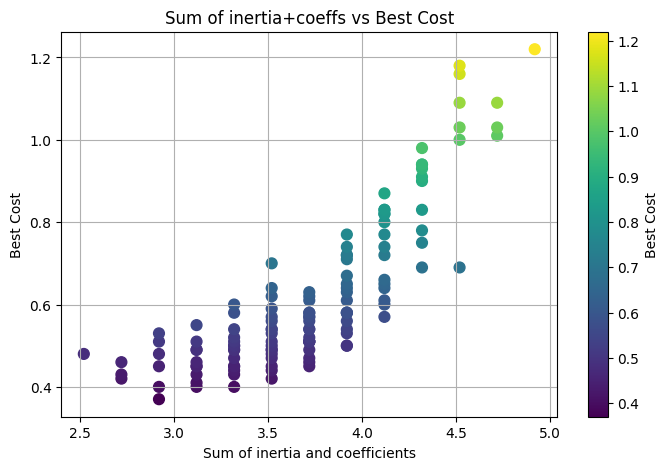

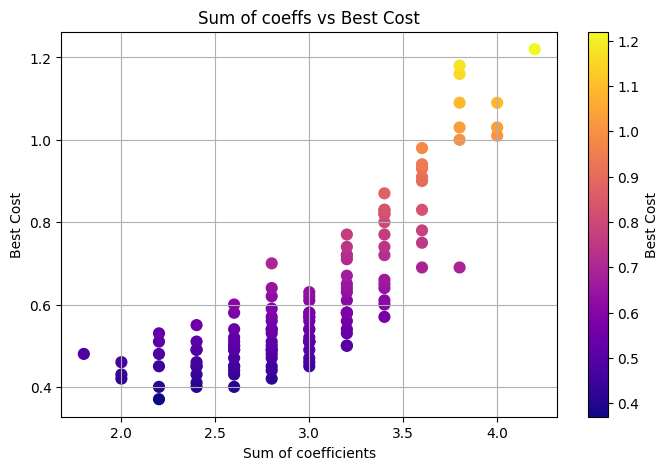

In [3]:
# Plot relationship between sum(inertia+coeffs) and best cost
import matplotlib.pyplot as plt
if 'table_df' in locals() and 'sum(inertia+coeffs)' in table_df.columns and 'best cost' in table_df.columns:
    plt.figure(figsize=(8,5))
    plt.scatter(table_df['sum(inertia+coeffs)'], table_df['best cost'], c=table_df['best cost'], cmap='viridis', s=60)
    plt.xlabel('Sum of inertia and coefficients')
    plt.ylabel('Best Cost')
    plt.title('Sum of inertia+coeffs vs Best Cost')
    plt.colorbar(label='Best Cost')
    plt.grid(True)
    plt.show()
else:
    print('Required columns not found in table_df. Run the previous cell first.')

# Plot relationship between sum(coeffs) and best cost
if 'table_df' in locals() and 'sum(coeffs)' in table_df.columns and 'best cost' in table_df.columns:
    plt.figure(figsize=(8,5))
    plt.scatter(table_df['sum(coeffs)'], table_df['best cost'], c=table_df['best cost'], cmap='plasma', s=60)
    plt.xlabel('Sum of coefficients')
    plt.ylabel('Best Cost')
    plt.title('Sum of coeffs vs Best Cost')
    plt.colorbar(label='Best Cost')
    plt.grid(True)
    plt.show()
else:
    print('Required columns not found in table_df. Run the previous cell first.')


In [4]:
# Draw parallel coordinates for w_inertia, c_personal, c_social, c_global
# Each line represents a row from the previous table, colored by best cost (darker = better)
# If two lines coincide, the darker color (lower cost) should be drawn on top
import plotly.graph_objects as go
import pandas as pd

def plot_parallel_coords(table_df):
    # Use only the required columns
    axes = ['inertia', 'personal coeff', 'global coeff', 'social coeff']
    color_col = 'bin color'
    cost_col = 'best cost'
    # Sort so that lower cost (darker) is plotted last (on top)
    # Viridis: lower cost = lower bin = darker color
    # To ensure darker lines are on top, plot lightest (highest cost) first, darkest (lowest cost) last
    table_df_sorted = table_df.sort_values(cost_col, ascending=False).reset_index(drop=True)
    fig = go.Figure()
    for i, row in table_df_sorted.iterrows():
        y = [row[a] for a in axes]
        color = row[color_col]
        fig.add_trace(go.Scatter(
            x=axes,
            y=y,
            mode='lines+markers',
            line=dict(color=color, width=3),
            marker=dict(color=color, size=8),
            name=f"best_cost={row[cost_col]:.2f}",
            showlegend=False
        ))
    fig.update_layout(
        title="Parallel Coordinates: PSO Velocity Coefficients (colored by best cost)",
        xaxis_title="Parameter",
        yaxis_title="Value",
        template="plotly_white"
    )
    fig.update_xaxes(type='category')
    fig.show()

# Try to find the last table_df in scope (from previous cell)
if 'table_df' in locals() and not table_df.empty:
    plot_parallel_coords(table_df)
else:
    print("Run the previous cell to generate the table first.")
